In [1]:
%load_ext autoreload
%autoreload 2

# Setup

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np

from pathlib import Path

In [3]:
shard_dir = "/homefs/home/lux70/storage/data/cath/shards"
cath_metadata_fpath = "/homefs/home/lux70/storage/data/cath/description/cath-domain-list-S35.txt"
ckpt_dir = "/homefs/home/lux70/storage/plaid/checkpoints/hourglass_vq/"

In [4]:
from plaid.datasets import CATHShardedDataModule

# TODO: test with seq_len=512 with larger machine mem
dm = CATHShardedDataModule(
    shard_dir=shard_dir,
    seq_len=128,
)
dm.setup()


train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()
batch = next(iter(train_dataloader))
print(len(train_dataloader.dataset))

25508


In [5]:
def load_cath_metadata(fpath):
    df = pd.read_csv(fpath, sep="\s+", header=None)
    
    # from the README file
    columns = [
        "cath_id", # original name: "CATH domain name (seven characters)",
        "Class number",
        "Architecture number",
        "Topology number",
        "Homologous superfamily number",
        "S35 sequence cluster number",
        "S60 sequence cluster number",
        "S95 sequence cluster number",
        "S100 sequence cluster number",
        "S100 sequence count number",
        "Domain length",
        "Structure resolution (Angstroms)"
    ]
    
    df.columns = columns
    return df

df = load_cath_metadata(cath_metadata_fpath)

In [6]:
df.head()

,cath_id,Class number,Architecture number,Topology number,Homologous superfamily number,S35 sequence cluster number,S60 sequence cluster number,S95 sequence cluster number,S100 sequence cluster number,S100 sequence count number,Domain length,Structure resolution (Angstroms)
0,1oaiA00,1,10,8,10,1,1,1,1,1,59,1.00
1,3frhA01,1,10,8,10,2,1,1,1,1,58,1.20
2,4g3oA00,1,10,8,10,3,1,1,1,1,53,1.60
3,4heoA00,1,10,8,10,4,1,1,1,1,53,1.65
4,1oksA00,1,10,8,10,5,1,1,1,1,51,1.80


# Obtain compressed representations

In [7]:
from plaid.compression.hourglass_vq import HourglassVQLightningModule

ckpt_dir = Path(ckpt_dir)
compression_id = "8ebs7j9h"
ckpt_fpath = ckpt_dir / compression_id / "last.ckpt"
hourglass = HourglassVQLightningModule.load_from_checkpoint(ckpt_fpath)

using quantizer tanh


In [8]:
from plaid.esmfold.misc import batch_encode_sequences
import torch

In [9]:
device = torch.device("cuda")

sequences = []
cath_ids = []

all_x_c = []
all_m_d = []


for batch in train_dataloader:
    x, sequence, header = batch
    sequences.extend(sequence)
    cath_ids.extend(header)
    
    aatype, mask, _, _, _ = batch_encode_sequences(sequence)
    x = x.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():
        x_c, m_d = hourglass(x, mask.bool(), infer_only=True)
    
    all_x_c.append(x_c.cpu().numpy())
    all_m_d.append(m_d.cpu().numpy())


for batch in val_dataloader:
    x, sequence, header = batch
    sequences.extend(sequence)
    cath_ids.extend(header)
    
    aatype, mask, _, _, _ = batch_encode_sequences(sequence)
    x = x.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():
        x_c, m_d = hourglass(x, mask.bool(), infer_only=True)
    
    all_x_c.append(x_c.cpu().numpy())
    all_m_d.append(m_d.cpu().numpy())


all_x_c = np.concatenate(all_x_c, axis=0)
all_m_d = np.concatenate(all_m_d, axis=0)

In [10]:
import einops
md_broadcast = einops.repeat(all_m_d, "n l -> n l c", c = all_x_c.shape[-1])
xc_pooled = (all_x_c * md_broadcast).sum(axis=1) / md_broadcast.sum(axis=1)
print(xc_pooled.shape)

(31885, 4)


In [11]:
# %%time

# from sklearn.manifold import TSNE
# tsne = TSNE()
# tsne_emb = tsne.fit_transform(xc_pooled)

# Filter By Metadata

In [12]:
import numpy as np


embed_df = pd.DataFrame({"embedding_idx": np.arange(len(cath_ids)), "cath_id":cath_ids})
df = df.set_index("cath_id").join(embed_df.set_index("cath_id"), how='left', rsuffix="embed_")
print(df.shape)

print("Filter by those with preprocessed ESMFold embeddings")
trimmed_df = df[~df.embedding_idx.isna()]
trimmed_df['embedding_idx'] = trimmed_df.embedding_idx.astype(int)
print(df.shape)


print("Filter by those in classes 1, 2, or 3")
def fn(x):
    return x in [1,2,3]
    
even_more_trimmed_df = trimmed_df[trimmed_df['Class number'].map(fn)]
print(even_more_trimmed_df.shape)
even_more_trimmed_df.head()

(32388, 12)
Filter by those with preprocessed ESMFold embeddings
(32388, 12)
Filter by those in classes 1, 2, or 3
(19044, 12)


/tmp/ipykernel_5257/3555854741.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_df['embedding_idx'] = trimmed_df.embedding_idx.astype(int)


,Class number,Architecture number,Topology number,Homologous superfamily number,S35 sequence cluster number,S60 sequence cluster number,S95 sequence cluster number,S100 sequence cluster number,S100 sequence count number,Domain length,Structure resolution (Angstroms),embedding_idx
cath_id,,,,,,,,,,,,
1oaiA00,1,10,8,10,1,1,1,1,1,59,1.00,10990
4heoA00,1,10,8,10,4,1,1,1,1,53,1.65,24654
1oksA00,1,10,8,10,5,1,1,1,1,51,1.80,26866
1zv1A00,1,10,8,10,8,1,1,1,1,59,1.60,12627
2qhoD00,1,10,8,10,9,1,1,1,1,49,1.85,17508


In [13]:
data = even_more_trimmed_df.copy()
min_count = data['Class number'].value_counts().min()
print("min count", min_count)

data = pd.concat([
    data[data['Class number'] == 1].sample(min_count, random_state=1),
    data[data['Class number'] == 2].sample(min_count, random_state=1),
    data[data['Class number'] == 3].sample(min_count, random_state=1)
])

print(data.shape)

min count 4268
(12804, 12)


In [29]:
idx_order = data.embedding_idx.values
idx_order

filtered_xc = xc_pooled[idx_order]
filtered_xc.shape

(12804, 4)

# Dimensionality Reduction

## Compute TSNE

In [30]:
%%time


from sklearn.manifold import TSNE
import time

start = time.time()
tsne = TSNE()
tsne_emb = tsne.fit_transform(filtered_xc)
end = time.time()

print(f"{(end - start) / 60:.2f} seconds")

1.48 seconds
CPU times: user 1min 28s, sys: 27.6 ms, total: 1min 28s
Wall time: 1min 28s


## Combine data and visualize

In [31]:
data['tsne1'] = tsne_emb[:, 0]
data['tsne2'] = tsne_emb[:, 1]
print(data.shape)

(12804, 14)


<Axes: xlabel='tsne1', ylabel='tsne2'>

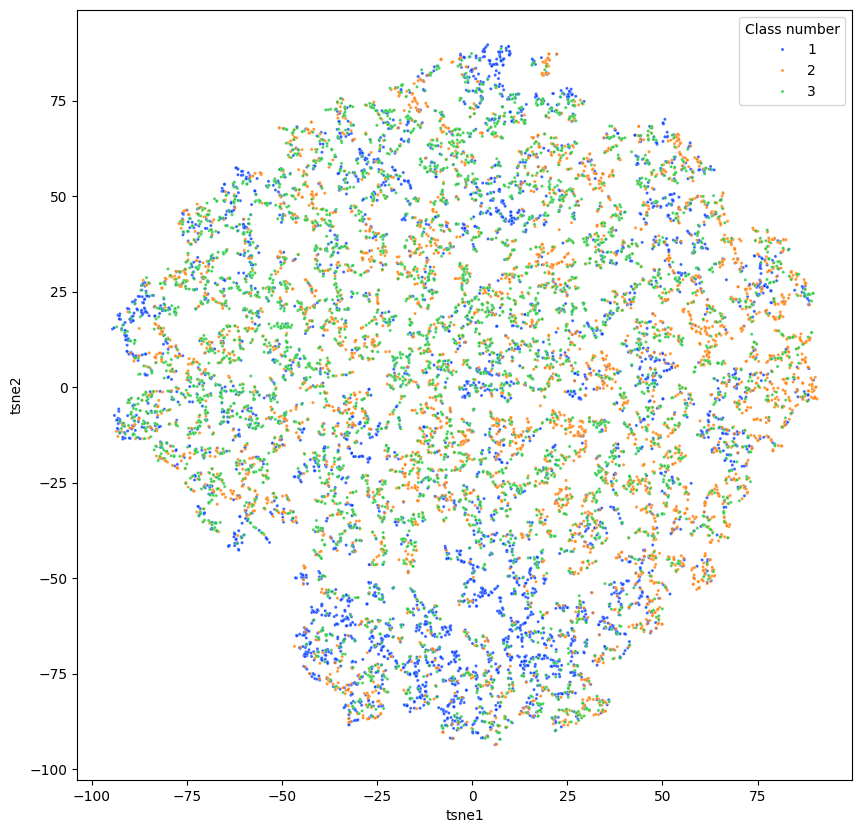

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=data, x='tsne1', y='tsne2', hue='Class number',s=5, palette="bright",alpha=0.8, ax=ax)

<Axes: xlabel='tsne1', ylabel='tsne2'>

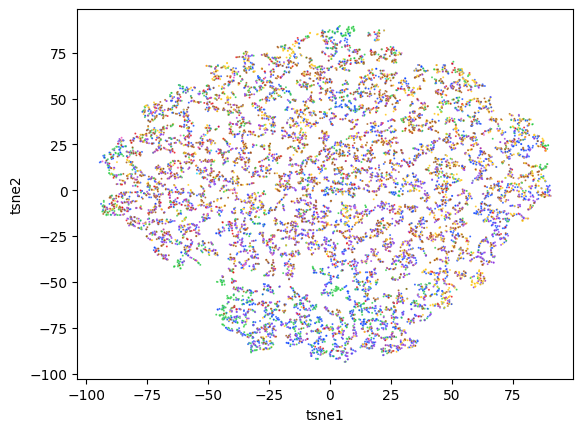

In [36]:
sns.scatterplot(data=data, x='tsne1', y='tsne2', hue='Architecture number',s=2, palette="bright",alpha=0.8, legend=False)

<Axes: xlabel='tsne1', ylabel='tsne2'>

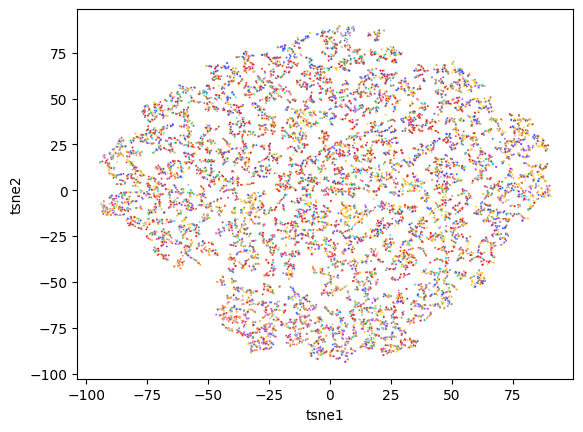

In [37]:
sns.scatterplot(data=data, x='tsne1', y='tsne2', hue='Topology number',s=2, palette="bright",alpha=0.8, legend=False)